This notebook: 
1. loads disp rate maps for intervals. Choose small regions/boxes to do following steps in. Do a few.
2. loads amp dispersion, wrap error, and high pass phase files.
3. set ranges of values for each criteria above.
4. loop through the ranges of criteria thresholds, count number of pix are in the range, calculate distribution of velocities in that range, save the mean, median, upper quartile, lower quartile, min, and max for box and whisker plot. 
5. Plot the range (center of each range) vs. the velocities (boxes and whiskers)
6. 

This notebook was copied and edited on 7-3-23.

***

Import stuff.

In [1]:
import os,sys
import glob
from osgeo import gdal
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from scipy import stats
import matplotlib.colors as mcolors
%matplotlib  widget 

Set up some variables and import paths.

In [2]:
# choose 'filt' or 'unfilt'
key1 = 'unfilt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
#driver=gdal.GetDriverByName('ISCE')

Load mask of reference pixels and extract y,x coords/indices of ref pixels

In [3]:
# load reference pixels mask 
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

Reference pixel mask loaded.


Set up the time intervals I already inverted for. Could use any of them with further analysis, but usually use 5. 

In [4]:
start_indices = [0,47,108,147,0,0,107]
end_indices = [46,107,146,numIgrams,88,numIgrams,153]
num_intervals = len(end_indices)
# the last one I just added (4-12-23) as a totally dry period

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
print(str(num_intervals)+' intervals.')

interval 0: 20170510-20181125
interval 1: 20181207-20200412
interval 2: 20200418-20201208
interval 3: 20201214-20220108
interval 4: 20170510-20191220
interval 5: 20170510-20220108
interval 6: 20200412-20210119
7 intervals.


Load in all the disp rate maps for all intervals.

In [5]:
disp_rates = np.ndarray((num_intervals,dy,dx),dtype='float')
disp_rates_errors = np.ndarray((num_intervals,dy,dx),dtype='float')
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'

for j in np.arange(5,6,1):    # num_intervals for all but the file doesn't exist in that form for all intervals
    # read in disp rate file + rmse file
    fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_HP_phs_jump_cutoff.r4'
    #errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'
    f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
    disp_rates[j] = f1.ReadAsArray()
    f1 = None
    # f1 = gdal.Open(saveDir+errorFileName, gdal.GA_ReadOnly)
    # disp_rates_errors[j] = f1.ReadAsArray()
    # f1 = None
    print('interval '+str(j)+' disp rate map loaded.')

interval 5 disp rate map loaded.


Define some boxes I want to analyze in further detail.

In [6]:
%%script echo skipping
# define boxes I want to look at 
box1x = [2300,2800];  box1dx = box1x[1]-box1x[0]
box1y = [300, 400];   box1dy = box1y[1]-box1y[0]
box2x = [1500, 2000]; box2dx = box2x[1]-box2x[0]
#box2y = [75, 175];    
box2y = [125, 200];   box2dy = box2y[1]-box2y[0]
box3x = [3500, 4000];  box3dx = box3x[1]-box3x[0]
box3y = [725, 800];   box3dy = box3y[1]-box3y[0]
box4x = [2150,2650];  box4dx = box4x[1]-box4x[0]
box4y = [600, 700];   box4dy = box4y[1]-box4y[0]

skipping


In [7]:
%%script echo skipping
# define second set of boxes. First ones weren't good enough.
box1x = [3000,3500];  box1dx = box1x[1]-box1x[0]
box1y = [300, 400];   box1dy = box1y[1]-box1y[0]
box2x = [2000, 2500]; box2dx = box2x[1]-box2x[0] 
box2y = [125, 200];   box2dy = box2y[1]-box2y[0]
box3x = [3500, 4000];  box3dx = box3x[1]-box3x[0]
box3y = [650, 750];   box3dy = box3y[1]-box3y[0]
box4x = [2500,3000];  box4dx = box4x[1]-box4x[0]
box4y = [600, 700];   box4dy = box4y[1]-box4y[0]
boxes = ['box1','box2','box3','box4']
numBoxes=len(boxes)
print(str(numBoxes)+' boxes.')

skipping


In [8]:
# define third set of boxes. Second ones weren't good enough.
box1x = [3500, 4000];  box1dx = box1x[1]-box1x[0]
box1y = [425, 525];   box1dy = box1y[1]-box1y[0]
box2x = [3500, 4000]; box2dx = box2x[1]-box2x[0] 
box2y = [200, 300];   box2dy = box2y[1]-box2y[0]
box3x = [3500, 4000];  box3dx = box3x[1]-box3x[0]
box3y = [0, 100];   box3dy = box3y[1]-box3y[0]
# box4x = [3500, 4000];  box4dx = box4x[1]-box4x[0]
# box4y = [1000,1100];   box4dy = box4y[1]-box4y[0]
# New box 4 in lower elevations
box4x = [2250, 2750];  box4dx = box4x[1]-box4x[0]
box4y = [425, 525];   box4dy = box4y[1]-box4y[0]

boxes = ['box1','box2','box3','box4']
numBoxes=len(boxes)
print(str(numBoxes)+' boxes.')

4 boxes.


Plot the defined boxes over the displacement rate map for interval of choice. Here I use the average displacement rate between disp rate maps for all intervals.

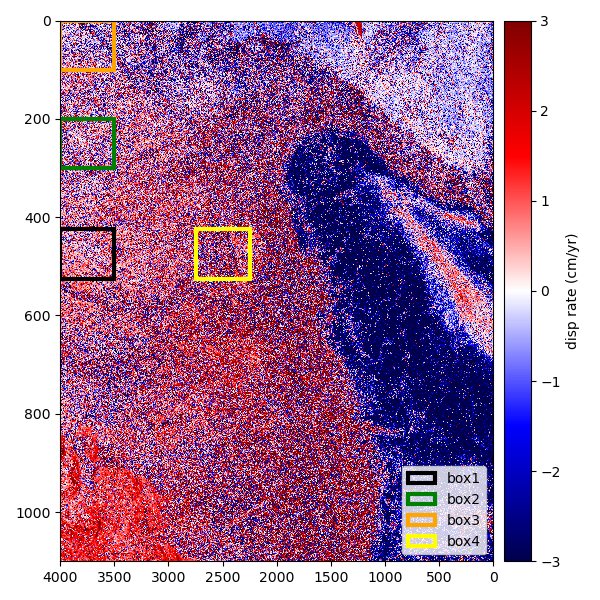

In [9]:
# plot them.
plt.figure(figsize=(6,6),tight_layout=True)
# plt.imshow(np.mean(disp_rates,axis=0), aspect='auto', vmin=-3.0,vmax=3.0,\
#             interpolation='nearest')
plt.imshow(disp_rates[5], aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
plt.legend(loc='lower right')
plt.show()

This plots the same boxes over each time interval's disp rate map individually.

In [10]:
%%script echo skipping
# plot them.
plt.figure(figsize=(8,16),tight_layout=True); count=1
for i in range(num_intervals):
    plt.subplot(4,2,count)
    plt.imshow(disp_rates[i], aspect='auto', vmin=-3.0,vmax=3.0,\
                interpolation='nearest')
    plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
    plt.set_cmap('seismic')
    plt.xlim([dx,0]); plt.ylim([dy,0])
    #plt.xticks([]); plt.yticks([])
    plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
    plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
    plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
    plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
    plt.legend(loc='lower right')
    plt.title('interval '+str(i)+'\ndates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
    count = count+1
plt.show()

skipping


Now load files:
1. amp dispersion
2. triplet unwrapping consistency/wrap errors
3. high pass phase 

In [11]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

file_name = 'amp_dispersion.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
amp_dispersion = f1.ReadAsArray(); f1 = None
print('Amplitude dispersion for each pixel loaded.')

file_name = 'unfilt_unwrapped/wrap_err.i1' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
wrap_err = f1.ReadAsArray(); f1 = None
print('wrap errors for each pixel loaded.')

file_name = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/hpcor.r4' 
f1 = gdal.Open(file_name, gdal.GA_ReadOnly)
hp = f1.ReadAsArray(); f1 = None
# cropped area
x1 = 18000; x2 = 14000
y1 = 2100; y2 = 1000
hp_phs = hp[y2:y1,x2:x1]
print('high pass phase for each pixel loaded.')

Amplitude dispersion for each pixel loaded.
wrap errors for each pixel loaded.


high pass phase for each pixel loaded.


Plot the three criteria: average behavior of each pixel over entire interval. Only plot the boxes if so desired.

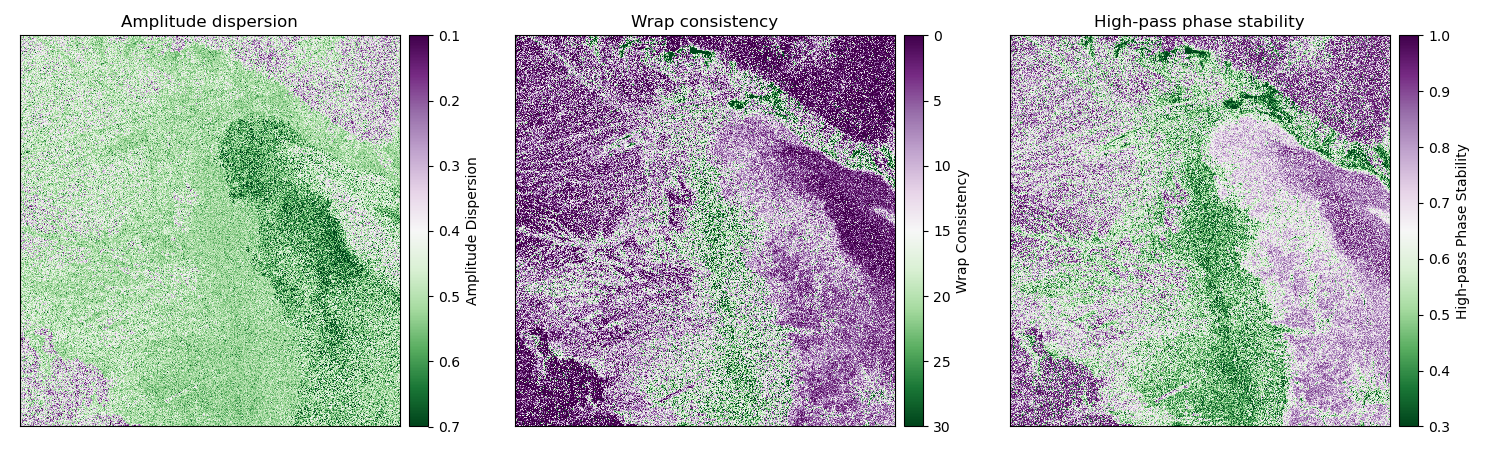

In [20]:
# want to plot the boxes?
plotBoxes = False

plt.figure(figsize=(15,4.5),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(amp_dispersion,aspect='auto',cmap='PRGn',interpolation='nearest',vmin=0.1,vmax=0.7)
cbar = plt.colorbar(orientation='vertical',pad=0.02,label='Amplitude Dispersion')
cbar.ax.invert_yaxis()
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
if plotBoxes==True:
    plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
    plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
    plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
    plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
    plt.legend(loc='lower right')
plt.title('Amplitude dispersion')

plt.subplot(1,3,2)
plt.imshow(wrap_err,aspect='auto',cmap='PRGn',interpolation='nearest',vmin=0,vmax=30)
cbar = plt.colorbar(orientation='vertical',pad=0.02,label='Wrap Consistency')
cbar.ax.invert_yaxis()
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
if plotBoxes==True:
    plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
    plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
    plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
    plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
plt.title('Wrap consistency')

plt.subplot(1,3,3)
plt.imshow(hp_phs,aspect='auto',cmap='PRGn_r',interpolation='nearest',vmin=0.3,vmax=1.0)
plt.colorbar(orientation='vertical',pad=0.02,label='High-pass Phase Stability')
plt.xlim([dx,0]); plt.ylim([dy,0]); plt.xticks([]); plt.yticks([])
if plotBoxes==True:
    plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
    plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
    plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
    plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
plt.title('High-pass phase stability')
plt.show()

Make a colormap where Nans are different color: try green.

In [13]:
seismic2 = plt.cm.get_cmap("seismic").copy()
seismic2.set_bad(color='green')
print('colormap made where NANs will be green.')

colormap made where NANs will be green.


Select one time interval to use from here down.

In [14]:
# which time interval? 
j = 5

Now just plot the one we're using. Interval 5 for now.

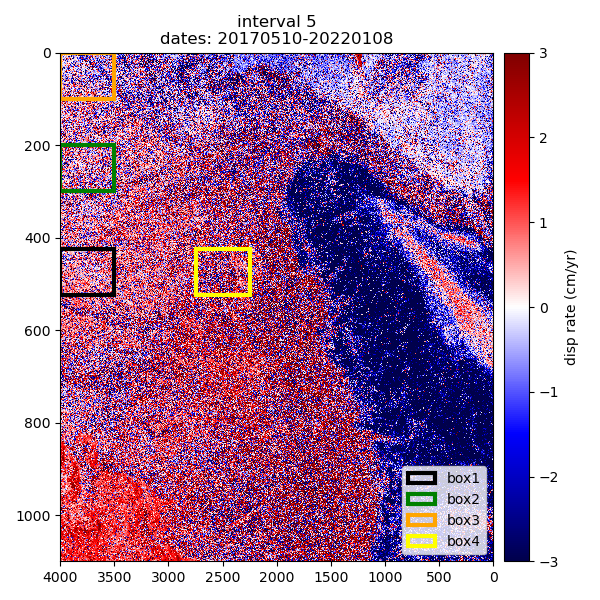

In [15]:
# plot the velocities with boxes.
plt.figure(figsize=(6,6),tight_layout=True)
plt.imshow(disp_rates[j], aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
#plt.xticks([]); plt.yticks([])
plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
plt.legend(loc='lower right')
plt.title('interval '+str(j)+'\ndates: '+str(dates[start_indices[j]])+'-'+str(dates[end_indices[j]]))
plt.show()

In [16]:
# choose one box
boxKey = 'box1'
if boxKey == 'box1':
    boxX = box1x; boxY = box1y; boxdx = box1dx;  boxdy = box1dy; print('using box 1.')
elif boxKey == 'box2':
    boxX = box2x; boxY = box2y; boxdx = box2dx;  boxdy = box2dy; print('using box 2.')
elif boxKey == 'box3':
    boxX = box3x; boxY = box3y; boxdx = box3dx;  boxdy = box3dy; print('using box 3.')
elif boxKey == 'box4':
    boxX = box4x; boxY = box4y; boxdx = box4dx;  boxdy = box4dy; print('using box 4.') 
print('box is '+str(boxdy)+' by '+str(boxdx)+' pixels. '+str(boxdx*boxdy)+' total.')

using box 1.
box is 100 by 500 pixels. 50000 total.


Pull out the chosen box section of the disp map and the criteria maps.

In [17]:
amp_disp_box = amp_dispersion[boxY[0]:boxY[1],boxX[0]:boxX[1]]
wrap_err_box = wrap_err[boxY[0]:boxY[1],boxX[0]:boxX[1]]
hp_phs_box = hp_phs[boxY[0]:boxY[1],boxX[0]:boxX[1]]
disps_box = disp_rates[j,boxY[0]:boxY[1],boxX[0]:boxX[1]]

print('values within box extracted. Box is: '+str(boxdy)+' x '+str(boxdx)+'.')

values within box extracted. Box is: 100 x 500.


Plot a histogram of disp rate values in the box chosen.

mean: 0.335386568188604
median: 0.4363945871591568
std: 1.5268288699281334


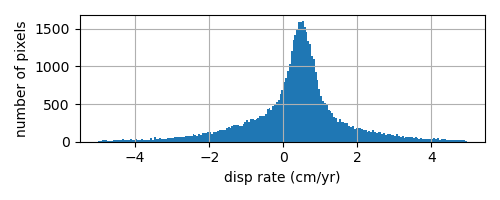

In [18]:
print('mean: '+str(np.mean((disps_box).flatten())))
print('median: '+str(np.median((disps_box).flatten())))
print('std: '+str(np.std((disps_box).flatten())))
plt.figure(figsize=(5,2),tight_layout=True)
plt.grid()
bins = np.arange(-5,5,0.05)
plt.hist((disps_box).flatten(),bins=bins)
plt.ylabel('number of pixels')
plt.xlabel('disp rate (cm/yr)')
plt.show() 

Find min, max, median, and 1sigma above, 1sigma below values for each dataset. This helps to choose the ranges and number of bins for future histograms and plots. Right now everything is set for interval 5, box1.

In [19]:
%%script echo skipping
print('Amp Dispersion:')
temp = amp_disp_box.flatten()
#print(np.shape(temp))
print('min: '+str(min(temp)))
print('max: '+str(max(temp)))
print('median: '+str(np.median(temp)))
print('mean: '+str(np.mean(temp)))
print('sigma: '+str(np.std(temp)))
print('median+3sigma: '+str(np.median(temp)+3*np.std(temp)))
print('median-3sigma: '+str(np.median(temp)-3*np.std(temp)))

print('\nWrap Error:')
temp = wrap_err_box.flatten()
#print(np.shape(temp))
print('min: '+str(min(temp)))
print('max: '+str(max(temp)))
print('median: '+str(np.median(temp)))
print('mean: '+str(np.mean(temp)))
print('sigma: '+str(np.std(temp)))
print('median+3sigma: '+str(np.median(temp)+3*np.std(temp)))
print('median-3sigma: '+str(np.median(temp)-3*np.std(temp)))

print('\nhp phase:')
temp = hp_phs_box.flatten()
#print(np.shape(temp))
print('min: '+str(min(temp)))
print('max: '+str(max(temp)))
print('median: '+str(np.median(temp)))
print('mean: '+str(np.mean(temp)))
print('sigma: '+str(np.std(temp)))
print('median+3sigma: '+str(np.median(temp)+3*np.std(temp)))
print('median-3sigma: '+str(np.median(temp)-3*np.std(temp)))

skipping


Do 49 ranges of amp disps and hp phase, and 31 ranges for wrap consistency/error. Wrap error values are all integers so can't divide into bins that are some decimal number wide.

In [20]:
num_ranges = 49
num_ranges_we = 30

# chose these manually based on previous cell results.
amp_disps = np.linspace(0.0,0.65,num_ranges+1)
print('amp disp values: '+str(amp_disps)+', '+str(np.shape(amp_disps)))
wrap_errs = np.linspace(0,30,num_ranges_we+1)
print('wrap err values: '+str(wrap_errs)+', '+str(np.shape(wrap_errs)))
hp_phss = np.linspace(0.3,1.0,num_ranges+1)
print('hp phs values: '+str(hp_phss)+', '+str(np.shape(hp_phss)))

print(str(num_ranges)+' ranges of criteria to loop through.')

amp disp values: [0.         0.01326531 0.02653061 0.03979592 0.05306122 0.06632653
 0.07959184 0.09285714 0.10612245 0.11938776 0.13265306 0.14591837
 0.15918367 0.17244898 0.18571429 0.19897959 0.2122449  0.2255102
 0.23877551 0.25204082 0.26530612 0.27857143 0.29183673 0.30510204
 0.31836735 0.33163265 0.34489796 0.35816327 0.37142857 0.38469388
 0.39795918 0.41122449 0.4244898  0.4377551  0.45102041 0.46428571
 0.47755102 0.49081633 0.50408163 0.51734694 0.53061224 0.54387755
 0.55714286 0.57040816 0.58367347 0.59693878 0.61020408 0.62346939
 0.63673469 0.65      ], (50,)
wrap err values: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.], (31,)
hp phs values: [0.3        0.31428571 0.32857143 0.34285714 0.35714286 0.37142857
 0.38571429 0.4        0.41428571 0.42857143 0.44285714 0.45714286
 0.47142857 0.48571429 0.5        0.51428571 0.52857143 0.54285714
 0.55714286 0.57142857 0.58571429 0.6        0.614

Define a function to take a masked array and return the same array but with Nans instead of ---'s 

In [21]:
def masked_pix_to_nans(masked_array,dy,dx):
    mask_y,mask_x = np.nonzero(masked_array)
    mask = np.zeros((dy,dx))
    mask[mask_y,mask_x] = 1.0
    Nans_y,Nans_x = np.where(mask==0)
    ab = masked_array
    ab[Nans_y,Nans_x] = np.nan
    return ab

Loop through the ranges and mask the velocity map based on that range. 

In [22]:
# this holds the masked maps for each range of criteria values, with masked values turned into Nans 
amp_disp_masked = np.ndarray((num_ranges,boxdy*boxdx),dtype='float')
wrap_err_masked = np.ndarray((num_ranges_we,boxdy*boxdx),dtype='float')
hp_phs_masked = np.ndarray((num_ranges,boxdy*boxdx),dtype='float')
# initialize arrays that keep the number of pixels used in each range
num_pix_amp_disp = np.ndarray((num_ranges),dtype='int')
num_pix_wrap_err = np.ndarray((num_ranges_we),dtype='int')
num_pix_hp_phs = np.ndarray((num_ranges),dtype='int')

for i in range(num_ranges): #num_ranges
    # amp disp
    amp_disp_temp = np.ma.masked_where(amp_disp_box<=amp_disps[i],disps_box)   # mask where values are smaller than range
    amp_disp_temp = np.ma.masked_where(amp_disp_box>amp_disps[i+1],amp_disp_temp) # mask where values are larger than range
    amp_disp_masked[i] = masked_pix_to_nans(amp_disp_temp,boxdy,boxdx).flatten()
    num_pix_amp_disp[i] = np.count_nonzero(~np.isnan(amp_disp_masked[i])) # count number of non-Nans
    
    # hp phase
    hp_phs_temp = np.ma.masked_where(hp_phs_box<=hp_phss[i],disps_box)   # mask where values are smaller than range
    hp_phs_temp = np.ma.masked_where(hp_phs_box>hp_phss[i+1],hp_phs_temp) # mask where values are larger than range
    hp_phs_masked[i] = masked_pix_to_nans(hp_phs_temp,boxdy,boxdx).flatten()
    num_pix_hp_phs[i] = np.count_nonzero(~np.isnan(hp_phs_masked[i]))

for i in range(num_ranges_we):
    # wrap error
    wrap_err_temp = np.ma.masked_where(wrap_err_box<wrap_errs[i],disps_box)   # mask where values are smaller than range
    wrap_err_temp = np.ma.masked_where(wrap_err_box>=wrap_errs[i+1],wrap_err_temp) # mask where values are larger than range
    wrap_err_masked[i] = masked_pix_to_nans(wrap_err_temp,boxdy,boxdx).flatten()
    num_pix_wrap_err[i] = np.count_nonzero(~np.isnan(wrap_err_masked[i]))

print(str(boxKey)+' masked and pixels counted.')

box1 masked and pixels counted.


This is a demo of kernel density estimation. That means that it estimates a histogram shape based on a dataset. Used at the end of this notebook. DO I NEED IT HERE?


Begin kernel density estimation demo 

Source data points (normal): 
[ 1.76  0.4   0.98  2.24  1.87 -0.98  0.95 -0.15 -0.1   0.41  0.14  1.45
  0.76  0.12  0.44  0.33  1.49 -0.21  0.31 -0.85 -2.55]

Generating estimated PDF function from source x_data 

Feeding points to KDE estimated PDF: 


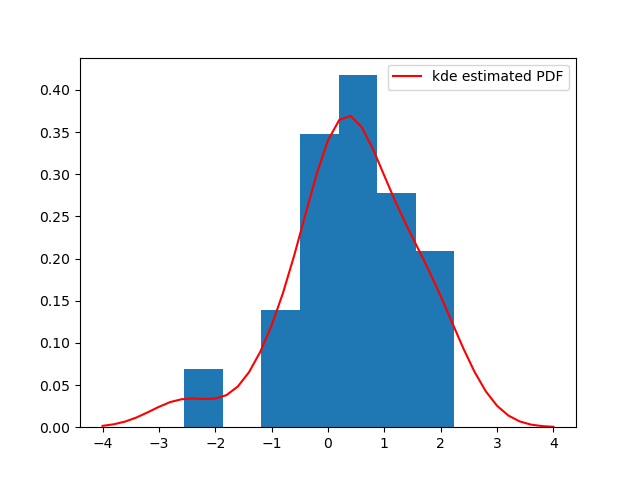


End demo 


In [23]:
# kde_demo.py

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

print("\nBegin kernel density estimation demo ")

np.random.seed(0)

x_data = np.array([
  1.76,  0.40,  0.98,  2.24,  1.87, -0.98,
  0.95, -0.15, -0.10,  0.41,  0.14,  1.45,
  0.76,  0.12,  0.44,  0.33,  1.49, -0.21,
  0.31, -0.85, -2.55])
print("\nSource data points (normal): ")
print(x_data)

print("\nGenerating estimated PDF function from source x_data ")
gkde_obj = stats.gaussian_kde(x_data)

x_pts = np.linspace(-4, +4, 41)
print("\nFeeding points to KDE estimated PDF: ")
estimated_pdf = gkde_obj.evaluate(x_pts)

# print("\nEstimated y data points from KDE: ")
# print(estimated_pdf)

y_normal = stats.norm.pdf(x_pts)

plt.figure()
plt.hist(x_data, bins=7, density=1.0)
plt.plot(x_pts, estimated_pdf, label="kde estimated PDF", \
 color="r")
plt.legend()
plt.show()

print("\nEnd demo ")

Calculate the center criteria value for each criteria range. For plotting.

In [24]:
amp_disp_centers = np.diff(amp_disps)/2+amp_disps[0:-1]
#wrap_err_centers = np.diff(wrap_errs)/2+wrap_errs[0:-1]
# this is what I used for wrap-errs instead
#wrap_errs = np.linspace(0,30,num_ranges_we+1)
hp_phs_centers = np.diff(hp_phss)/2+hp_phss[0:-1]

print('Midpoints of ranges calculated.')

Midpoints of ranges calculated.


Load in GNSS-modelled disp rates for this cropped area and compare to rates calculated for ranges of criteria.

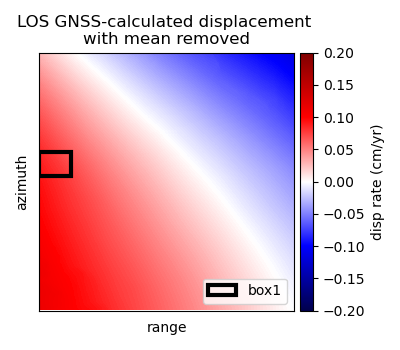

Mean GNSS-derived velocity in box1: 0.079120144 cm/yr


In [25]:
# read in los.r4 file
fileName = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/v_mean/los.r4'
f1 = gdal.Open(fileName, gdal.GA_ReadOnly)
losFull = f1.ReadAsArray()
f1 = None
# convert to cm/yr 
losFull = losFull/10.0

# cropped area
x1 = 18000
x2 = 14000
y1 = 2100
y2 = 1000

# crop out my area
los = losFull[y2:y1,x2:x1]
# subtract out the mean of the ref pixel vals/vels
los = los - np.mean(los[np.nonzero(ref_mask)])

# plot it.
plt.figure(figsize=(4,3.5),tight_layout=True)
plt.imshow(los, aspect='auto',interpolation='nearest',vmin=-0.2,vmax=0.2)
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.gca().add_patch(Rectangle((box1x[0],box1y[0]),box1dx,box1dy,edgecolor='k',facecolor='none',lw=3,label='box1'))
# plt.gca().add_patch(Rectangle((box2x[0],box2y[0]),box2dx,box2dy,edgecolor='green',facecolor='none',lw=3,label='box2'))
# plt.gca().add_patch(Rectangle((box3x[0],box3y[0]),box3dx,box3dy,edgecolor='orange',facecolor='none',lw=3,label='box3'))
# plt.gca().add_patch(Rectangle((box4x[0],box4y[0]),box4dx,box4dy,edgecolor='yellow',facecolor='none',lw=3,label='box4'))
plt.legend(loc='lower right')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xlabel('range'); plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.title('LOS GNSS-calculated displacement \nwith mean removed')
plt.show()

# pull out values for specific box and take mean 
losBox = np.mean(los[boxY[0]:boxY[1],boxX[0]:boxX[1]].flatten())
print('Mean GNSS-derived velocity in '+str(boxKey)+': '+str(losBox)+' cm/yr')


Plot GNSS-derived velocities without the boxes, for supplemental figure. Use perceptually-equal colormap too. 

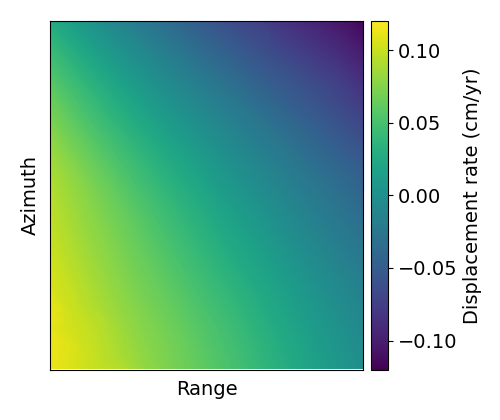

In [26]:
# plot it.
plt.figure(figsize=(5,4.2),tight_layout=True)
plt.rcParams.update({'font.size': 14})
plt.imshow(los, aspect='auto',interpolation='none',vmin=-0.12,vmax=0.12)
plt.colorbar(orientation='vertical',pad=0.02,label='Displacement rate (cm/yr)')
#plt.plot(mask_x,mask_y,'k.',ms=0.1)
plt.set_cmap('viridis')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xlabel('Range'); plt.ylabel('Azimuth')
plt.xticks([]); plt.yticks([])
#plt.title('LOS GNSS-modelled displacement rates')
#plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/GNSS_fig.png',transparent=True)
plt.show()

Plot mean and median for each criteria and all its ranges. Underlying, plot histogram of pixel occurance for that interval. 

/tmp/ipykernel_3960454/1799467330.py:40: RuntimeWarning: Mean of empty slice
  plt.plot(amp_disp_centers,np.nanmean(amp_disp_masked,axis=1),'^',markersize=10,c='green',label='Mean',zorder=10)
/home/ocp4/miniforge3/envs/earthscope_insar/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


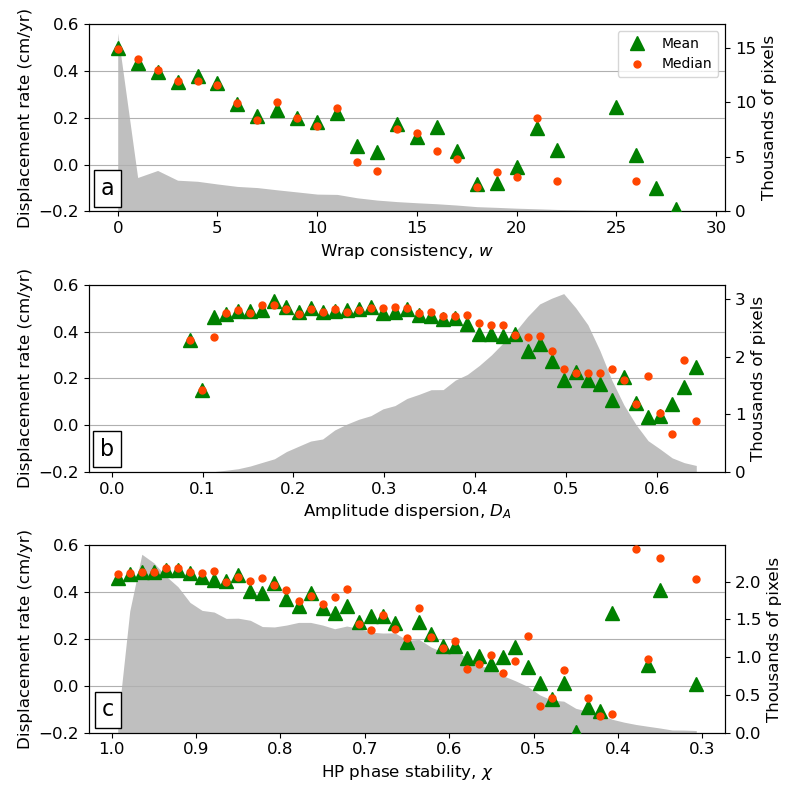

In [34]:
# Fixed the order of plotting on 1-12-24. Zorder not working at all so had to change what I plotted first and on which axis.
plt.figure(figsize=(8,8),tight_layout=True)
props = dict(boxstyle='square',facecolor='white',edgecolor='black')
lows_we = np.zeros(num_ranges_we)
lows = np.zeros(num_ranges)

Ymax = 0.6
Ymin = -0.2

ax1 = plt.subplot(3,1,1)
ax1.fill_between(wrap_errs[0:-1],lows_we,num_pix_wrap_err/1000,color='k',alpha=0.25,zorder=0,linewidth=0)
ylow,yhigh = ax1.get_ylim()
ax1.set_ylim([0,yhigh])
ax1.set_ylabel('Thousands of pixels')
ax1.set_xlabel('Wrap consistency, $\it{w}$')
ax2 = ax1.twinx()
#ax2.axhline(losBox,0,1,color='b',linestyle='--',label='GNSS velocity')
ax2.grid(axis='y')
ax2.plot(wrap_errs[0:-1],np.nanmean(wrap_err_masked,axis=1),'^',markersize=10,c='green',label='Mean',zorder=10)
ax2.plot(wrap_errs[0:-1],np.nanmedian(wrap_err_masked,axis=1),'.',markersize=10,c='orangered',label='Median',zorder=20)
#ax2.set_ylim([-0.3,0.3])
ax2.set_ylim([Ymin,Ymax])
ax2.set_ylabel('Displacement rate (cm/yr)')
plt.text(0.04,0.06,'a',fontsize=16,bbox=props,horizontalalignment='right',verticalalignment='bottom',transform=plt.gca().transAxes)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
plt.legend(loc='upper right',fontsize=10,framealpha=0.8)

ax1 = plt.subplot(3,1,2)
ax1.fill_between(amp_disp_centers,lows,num_pix_amp_disp/1000,color='k',alpha=0.25,zorder=0,linewidth=0)
ylow,yhigh = ax1.get_ylim()
ax1.set_ylim([0,yhigh])
ax1.set_ylabel('Thousands of pixels')
ax1.set_xlabel('Amplitude dispersion, $\it{D_A}$')
ax2 = ax1.twinx()
#ax2.axhline(losBox,0,1,color='b',linestyle='--',label='GNSS velocity')
ax2.grid(axis='y')
plt.plot(amp_disp_centers,np.nanmean(amp_disp_masked,axis=1),'^',markersize=10,c='green',label='Mean',zorder=10)
plt.plot(amp_disp_centers,np.nanmedian(amp_disp_masked,axis=1),'.',markersize=10,c='orangered',label='Median',zorder=20)
#ax2.set_ylim([-0.3,0.3])
ax2.set_ylim([Ymin,Ymax])
ax2.set_ylabel('Displacement rate (cm/yr)')
plt.text(0.04,0.06,'b',fontsize=16,bbox=props,horizontalalignment='right',verticalalignment='bottom',transform=plt.gca().transAxes)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

ax1 = plt.subplot(3,1,3)
ax1.fill_between(hp_phs_centers,lows,num_pix_hp_phs/1000,color='k',alpha=0.25,zorder=0,linewidth=0)
ylow,yhigh = ax1.get_ylim()
ax1.set_ylim([0,yhigh])
ax1.set_ylabel('Thousands of pixels')
ax1.set_xlabel('HP phase stability, $\it{\u03C7}$')
ax2 = ax1.twinx()
#ax2.axhline(losBox,0,1,color='b',linestyle='--',label='GNSS velocity')
ax2.grid(axis='y')
plt.plot(hp_phs_centers,np.nanmean(hp_phs_masked,axis=1),'^',markersize=10,c='green',label='Mean',zorder=10)
plt.plot(hp_phs_centers,np.nanmedian(hp_phs_masked,axis=1),'.',markersize=10,c='orangered',label='Median',zorder=20)
#ax2.set_ylim([-0.3,0.3])
ax2.set_ylim([Ymin,Ymax])
xmin,xmax = plt.gca().get_xlim() # extraxt xlim so we can plot it reversed.
plt.xlim([xmax,xmin])            # reverse the axis so "good" values remain on the left.
ax2.set_ylabel('Displacement rate (cm/yr)')
plt.text(0.04,0.06,'c',fontsize=16,bbox=props,horizontalalignment='right',verticalalignment='bottom',transform=plt.gca().transAxes)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

#plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/box1_disps_LS_paper.png',transparent=True)
plt.show()

To plot data on a limited y-axes, need to show which datapoints fall outside of that range at the "bad" end of the criteria (right side for each plot). SO, separate into datasets in and outside the criteria range to plot them as different symbols. Only plotting the median here to simplify the plot from the one above.

In [35]:
# Fixed the order of plotting on 1-17-24. This will be for LS paper.

# separate the data points within the ylim range from the ones that aren't in the ylim range. 
y_lower_lim = Ymin
y_upper_lim = Ymax

# wrap consistency
wrap_err_X_to_plot = wrap_errs[0:-1]
wrap_err_disps_to_plot = np.nanmedian(wrap_err_masked,axis=1)
wrap_err_in_axes_X = wrap_err_X_to_plot[wrap_err_disps_to_plot>=y_lower_lim]
wrap_err_in_axes_Y =  wrap_err_disps_to_plot[wrap_err_disps_to_plot>=y_lower_lim]
wrap_err_outside_axes_X = wrap_err_X_to_plot[wrap_err_disps_to_plot<y_lower_lim]
wrap_err_outside_axes_Y =  wrap_err_disps_to_plot[wrap_err_disps_to_plot<y_lower_lim]*0 + y_lower_lim

# amplitude dispersion 
# amp_disp_centers
amp_disp_disps_to_plot = np.nanmedian(amp_disp_masked,axis=1)
amp_disp_in_axes_X = amp_disp_centers[amp_disp_disps_to_plot>=y_lower_lim]
amp_disp_in_axes_Y =  amp_disp_disps_to_plot[amp_disp_disps_to_plot>=y_lower_lim]
amp_disp_outside_axes_X = amp_disp_centers[amp_disp_disps_to_plot<y_lower_lim]
amp_disp_outside_axes_Y =  amp_disp_disps_to_plot[amp_disp_disps_to_plot<y_lower_lim]*0 + y_lower_lim
# ^THESE ARE EMPTY 

# HP phase stability 
# hp_phs_centers
hp_phs_disps_to_plot = np.nanmedian(hp_phs_masked,axis=1)
# needs to be above lower limit
hp_phs_in_axes_X = hp_phs_centers[hp_phs_disps_to_plot>=y_lower_lim]
hp_phs_in_axes_Y =  hp_phs_disps_to_plot[hp_phs_disps_to_plot>=y_lower_lim]
# and below upper limit
hp_phs_in_axes_X_2 = hp_phs_in_axes_X[hp_phs_in_axes_Y<y_upper_lim]
hp_phs_in_axes_Y_2 =  hp_phs_in_axes_Y[hp_phs_in_axes_Y<y_upper_lim]
# below
hp_phs_outside_axes_X = hp_phs_centers[hp_phs_disps_to_plot<y_lower_lim]
hp_phs_outside_axes_Y =  hp_phs_disps_to_plot[hp_phs_disps_to_plot<y_lower_lim]*0 + y_lower_lim
# above
hp_phs_above_axes_X = hp_phs_centers[hp_phs_disps_to_plot>y_upper_lim]
hp_phs_above_axes_Y =  hp_phs_disps_to_plot[hp_phs_disps_to_plot>y_upper_lim]*0 + y_upper_lim

print('datasets within y-range and outside y-range separated for plotting with different symbols.')

datasets within y-range and outside y-range separated for plotting with different symbols.


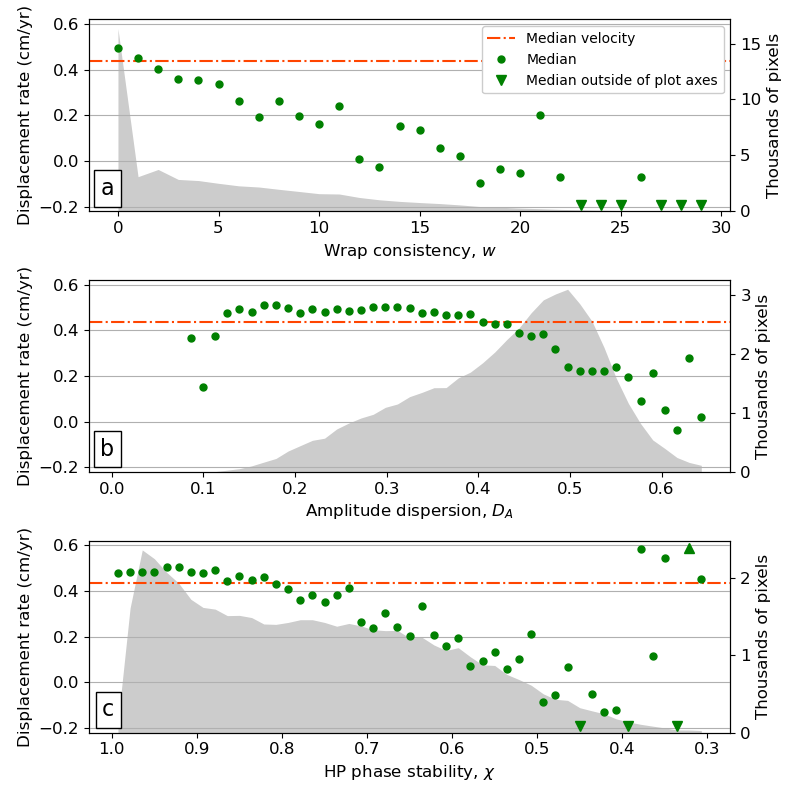

In [37]:
# plot it
plt.figure(figsize=(8,8),tight_layout=True)
props = dict(boxstyle='square',facecolor='white',edgecolor='black')
lows_we = np.zeros(num_ranges_we)
lows = np.zeros(num_ranges)
plt.rcParams.update({'font.size': 12})
# plot the median disp rate for the whole box too
rate_med = np.median((disps_box).flatten())
rate_mean = np.mean((disps_box).flatten())
buffer = 0.01

ax1 = plt.subplot(3,1,1)
ax1.fill_between(wrap_errs[0:-1],lows_we,num_pix_wrap_err/1000,color='k',alpha=0.2,zorder=0,linewidth=0)
ylow,yhigh = ax1.get_ylim()
ax1.set_ylim([0,yhigh])
ax1.set_ylabel('Thousands of pixels')
ax1.set_xlabel('Wrap consistency, $\it{w}$')
ax2 = ax1.twinx()
ax2.axhline(rate_med,0,1,color='orangered',linestyle='-.',label='Median velocity')
#ax2.axhline(losBox,0,1,color='b',linestyle='--',label='GNSS velocity')
#ax2.axhline(rate_mean,0,1,color='purple',linestyle='-.',label='Mean velocity')
ax2.grid(axis='y')
#ax2.plot(wrap_errs[0:-1],np.nanmean(wrap_err_masked,axis=1),'^',markersize=10,c='green',label='Mean',zorder=10)
ax2.plot(wrap_err_in_axes_X,wrap_err_in_axes_Y,'.',markersize=10,c='green',label='Median',zorder=20)
ax2.plot(wrap_err_outside_axes_X,wrap_err_outside_axes_Y+buffer,'v',markersize=7,c='green',label='Median outside of plot axes',zorder=20)
ax2.set_ylim([y_lower_lim-0.02,y_upper_lim+0.02])
ax2.set_ylabel('Displacement rate (cm/yr)')
plt.text(0.04,0.06,'a',fontsize=16,bbox=props,horizontalalignment='right',verticalalignment='bottom',transform=plt.gca().transAxes)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
plt.legend(loc='upper right',fontsize=10,framealpha=1.0)

ax1 = plt.subplot(3,1,2)
ax1.fill_between(amp_disp_centers,lows,num_pix_amp_disp/1000,color='k',alpha=0.2,zorder=0,linewidth=0)
ylow,yhigh = ax1.get_ylim()
ax1.set_ylim([0,yhigh])
ax1.set_ylabel('Thousands of pixels')
ax1.set_xlabel('Amplitude dispersion, $\it{D_A}$')
ax2 = ax1.twinx()
ax2.axhline(rate_med,0,1,color='orangered',linestyle='-.',label='Median velocity of all data shown')
#ax2.axhline(losBox,0,1,color='b',linestyle='--',label='GNSS velocity')
ax2.grid(axis='y')
#ax2.plot(amp_disp_centers,np.nanmean(amp_disp_masked,axis=1),'^',markersize=10,c='green',label='Mean',zorder=10)
ax2.plot(amp_disp_in_axes_X,amp_disp_in_axes_Y,'.',markersize=10,c='green',label='Median',zorder=20)
ax2.plot(amp_disp_outside_axes_X,amp_disp_outside_axes_Y+buffer,'v',markersize=7,c='green',zorder=20)
ax2.set_ylim([y_lower_lim-0.02,y_upper_lim+0.02])
ax2.set_ylabel('Displacement rate (cm/yr)')
plt.text(0.04,0.06,'b',fontsize=16,bbox=props,horizontalalignment='right',verticalalignment='bottom',transform=plt.gca().transAxes)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

ax1 = plt.subplot(3,1,3)
ax1.fill_between(hp_phs_centers,lows,num_pix_hp_phs/1000,color='k',alpha=0.2,zorder=0,linewidth=0)
ylow,yhigh = ax1.get_ylim()
ax1.set_ylim([0,yhigh])
ax1.set_ylabel('Thousands of pixels')
ax1.set_yticks(ticks=[0,1,2],labels=[0,1,2])
ax1.set_xlabel('HP phase stability, $\it{\u03C7}$')
ax2 = ax1.twinx()
#ax2.axhline(losBox,0,1,color='b',linestyle='--',label='GNSS velocity')
ax2.axhline(rate_med,0,1,color='orangered',linestyle='-.',label='Median velocity')
ax2.grid(axis='y')
#ax2.plot(hp_phs_centers,np.nanmean(hp_phs_masked,axis=1),'^',markersize=10,c='green',label='Mean',zorder=10)
ax2.plot(hp_phs_in_axes_X_2,hp_phs_in_axes_Y_2,'.',markersize=10,c='green',label='Median',zorder=20)
ax2.plot(hp_phs_outside_axes_X,hp_phs_outside_axes_Y+buffer,'v',markersize=7,c='green',zorder=20)
ax2.plot(hp_phs_above_axes_X,hp_phs_above_axes_Y-buffer,'^',markersize=7,c='green',zorder=20)
ax2.set_ylim([y_lower_lim-0.02,y_upper_lim+0.02])
xmin,xmax = plt.gca().get_xlim() # extraxt xlim so we can plot it reversed.
plt.xlim([xmax,xmin])            # reverse the axis so "good" values remain on the left.
ax2.set_ylabel('Displacement rate (cm/yr)')
plt.text(0.04,0.06,'c',fontsize=16,bbox=props,horizontalalignment='right',verticalalignment='bottom',transform=plt.gca().transAxes)
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
#plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/box1_disps_LS_paper.png',transparent=True)
plt.show()

Demo for how to use kernel density estimation for fitting a histogram shape to data. Used in next cell.

In [38]:
%%script echo skipping
print("\nBegin kernel density estimation demo ")

np.random.seed(0)

x_data = np.array([
  1.76,  0.40,  0.98,  2.24,  1.87, -0.98,
  0.95, -0.15, -0.10,  0.41,  0.14,  1.45,
  0.76,  0.12,  0.44,  0.33,  1.49, -0.21,
  0.31, -0.85, -2.55])
print("\nSource data points (normal): ")
print(x_data)

print("\nGenerating estimated PDF function from source x_data ")
gkde_obj = stats.gaussian_kde(x_data)

x_pts = np.linspace(-4, +4, 41)
print("\nFeeding points to KDE estimated PDF: ")
estimated_pdf = gkde_obj.evaluate(x_pts)

# print("\nEstimated y data points from KDE: ")
# print(estimated_pdf)

y_normal = stats.norm.pdf(x_pts)

plt.figure()
plt.hist(x_data, bins=7, density=1.0)
plt.plot(x_pts, estimated_pdf, label="kde estimated PDF", \
 color="r")
plt.legend()
plt.show()

print("\nEnd demo ")

skipping


Calculate the peak of the histogram fit for each criteria and its ranges that will be plotted in the following plot (heatmap of criteria vs. displacement rate within chosen box). Instead of picking maximum histogram value, which can be spurious, it's better to fit a kernel density function, then select the peak of that. Loops through and does that for each vertical slice of heat map.

In [39]:
# this holds the masked maps for each range of criteria values, with masked values turned into Nans 
amp_disp_masked = np.ndarray((num_ranges,boxdy*boxdx),dtype='float')
wrap_err_masked = np.ndarray((num_ranges_we,boxdy*boxdx),dtype='float')
hp_phs_masked = np.ndarray((num_ranges,boxdy*boxdx),dtype='float')
# initialize arrays that keep the number of pixels used in each range
num_pix_amp_disp = np.ndarray((num_ranges),dtype='int')
num_pix_wrap_err = np.ndarray((num_ranges_we),dtype='int')
num_pix_hp_phs = np.ndarray((num_ranges),dtype='int')
# initialize arrays that keep the location of peak value (disp rate) for each kernel-fit histogram 
ad_peaks = np.ndarray((num_ranges),dtype='float')
we_peaks = np.ndarray((num_ranges_we),dtype='float')
hp_peaks = np.ndarray((num_ranges),dtype='float')

for i in range(num_ranges): #num_ranges
    # amp disp
    amp_disp_temp = np.ma.masked_where(amp_disp_box<=amp_disps[i],disps_box)   # mask where values are smaller than range
    amp_disp_temp = np.ma.masked_where(amp_disp_box>amp_disps[i+1],amp_disp_temp) # mask where values are larger than range
    amp_disp_masked[i] = masked_pix_to_nans(amp_disp_temp,boxdy,boxdx).flatten()
    num_pix_amp_disp[i] = np.count_nonzero(~np.isnan(amp_disp_masked[i])) # count number of non-Nans
    # calculate the peak disp rate value for a kernel fit histogram to amp_disp_masked[i]
    x_data = amp_disp_masked[i]
    x_data = x_data[~np.isnan(x_data)]
    if np.shape(x_data)[0]<3:   # if no pixels lie in this range of criteria vals, nothing to fit hist distribution to. 
        ad_peaks[i] = np.nan
    else:
        gkde_obj = stats.gaussian_kde(x_data)
        x_pts = np.linspace(-10, 10, 1000)
        estimated_pdf = gkde_obj.evaluate(x_pts)
        ad_peaks[i] = x_pts[np.argmax(estimated_pdf)]
    
    # hp phase
    hp_phs_temp = np.ma.masked_where(hp_phs_box<=hp_phss[i],disps_box)   # mask where values are smaller than range
    hp_phs_temp = np.ma.masked_where(hp_phs_box>hp_phss[i+1],hp_phs_temp) # mask where values are larger than range
    hp_phs_masked[i] = masked_pix_to_nans(hp_phs_temp,boxdy,boxdx).flatten()
    num_pix_hp_phs[i] = np.count_nonzero(~np.isnan(hp_phs_masked[i]))
    # calculate the peak disp rate value for a kernel fit histogram to amp_disp_masked[i]
    x_data = hp_phs_masked[i]
    x_data = x_data[~np.isnan(x_data)]
    if np.shape(x_data)[0]<3:   # if no pixels lie in this range of criteria vals, nothing to fit hist distribution to. 
        hp_peaks[i] = np.nan
    else:
        gkde_obj = stats.gaussian_kde(x_data)
        x_pts = np.linspace(-10, 10, 1000)
        estimated_pdf = gkde_obj.evaluate(x_pts)
        hp_peaks[i] = x_pts[np.argmax(estimated_pdf)]

for i in range(num_ranges_we):
    # wrap error
    wrap_err_temp = np.ma.masked_where(wrap_err_box<=wrap_errs[i],disps_box)   # mask where values are smaller than range
    wrap_err_temp = np.ma.masked_where(wrap_err_box>wrap_errs[i+1],wrap_err_temp) # mask where values are larger than range
    wrap_err_masked[i] = masked_pix_to_nans(wrap_err_temp,boxdy,boxdx).flatten()
    num_pix_wrap_err[i] = np.count_nonzero(~np.isnan(wrap_err_masked[i]))
    # calculate the peak disp rate value for a kernel fit histogram to amp_disp_masked[i]
    x_data = wrap_err_masked[i]
    x_data = x_data[~np.isnan(x_data)]
    if np.shape(x_data)[0]<3:   # if no pixels lie in this range of criteria vals, nothing to fit hist distribution to. 
        we_peaks[i] = np.nan
    else:
        gkde_obj = stats.gaussian_kde(x_data)
        x_pts = np.linspace(-10, 10, 1000)
        estimated_pdf = gkde_obj.evaluate(x_pts)
        we_peaks[i] = x_pts[np.argmax(estimated_pdf)]

print(str(boxKey)+' masked and pixels counted.')

box1 masked and pixels counted.


Plot the heat map for each criteria vs. disp rate, then the peak of the histogram/kernel density function fit over top of it as points. There should be one point per midpoint of criteria ranges.

median rate in whole box: 0.4363945871591568


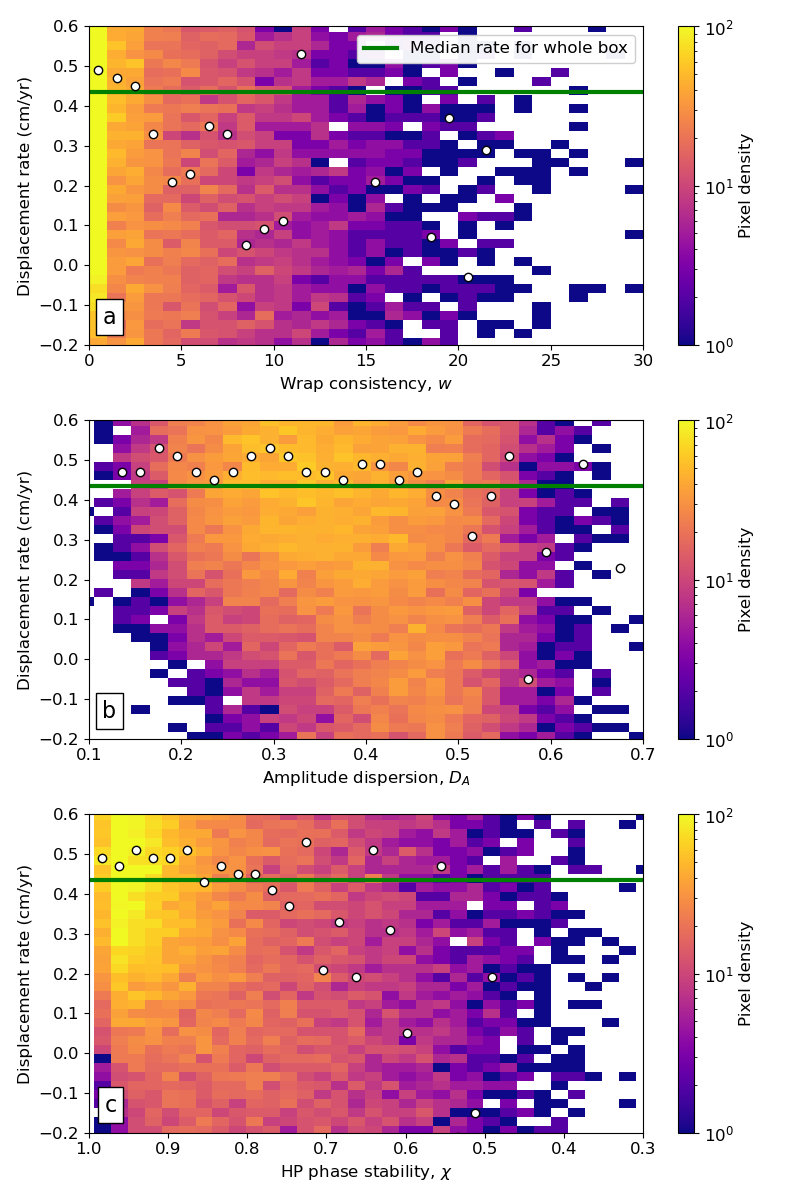

In [43]:
# plot all these metrics vs disp rate as 2d histograms/heat maps to see if there is a semblance of a linear trend in certain ranges. 
numBins=1000
ymin = -0.2
ymax = 0.6

# plot the median disp rate for the whole box too
rate_med = np.median((disps_box).flatten())
print('median rate in whole box: '+str(rate_med))

# plot it
plt.figure(figsize=(8,12),tight_layout=True)

# wrap consistency
plt.subplot(3,1,1)
h, xedges, yedges, img = plt.hist2d(wrap_err_box.flatten(),disps_box.flatten(),bins=[40,numBins],norm=mcolors.LogNorm(vmin=1,vmax=1e2))
we_peaks = np.ndarray((len(xedges)-1),dtype='float')
we_centers = np.diff(xedges)/2+xedges[0:-1]
for i in range(len(xedges)-1):
    temp = np.ma.masked_where(wrap_err_box<xedges[i],disps_box)
    temp = np.ma.masked_where(wrap_err_box>=xedges[i+1],temp)
    temp_masked = masked_pix_to_nans(temp,boxdy,boxdx).flatten()
    x_data = temp_masked[~np.isnan(temp_masked)]
    if np.shape(x_data)[0]<3:   # if no pixels lie in this range of criteria vals, nothing to fit hist distribution to. 
        we_peaks[i] = np.nan
    else:
        gkde_obj = stats.gaussian_kde(x_data)
        x_pts = np.linspace(-10, 10, 1000)
        estimated_pdf = gkde_obj.evaluate(x_pts)
        we_peaks[i] = x_pts[np.argmax(estimated_pdf)]
plt.plot(we_centers,we_peaks,'ow',markeredgecolor='k',zorder=100)
plt.colorbar(label='Pixel density')
plt.set_cmap('plasma')
plt.ylabel('Displacement rate (cm/yr)')
plt.xlabel('Wrap consistency, $\it{w}$')
plt.axhline(y=rate_med,xmin=0,xmax=1,color='g',linewidth=3,label='Median rate for whole box')
#plt.axhline(losBox,0,1,color='b',linestyle='--',linewidth=3,label='GNSS velocity')
plt.legend(loc='upper right',framealpha=0.95)
plt.text(0.05,0.05,'a',fontsize=16,bbox=props,horizontalalignment='right',verticalalignment='bottom',transform=plt.gca().transAxes)
plt.xlim([0,30])
plt.ylim([ymin,ymax])

# amplitude dispersion
plt.subplot(3,1,2)
h, xedges, yedges, img = plt.hist2d(amp_disp_box.flatten(),disps_box.flatten(),bins=[100,numBins],norm=mcolors.LogNorm(vmin=1,vmax=1e2))
ad_peaks = np.ndarray((len(xedges)-1),dtype='float')
ad_centers = np.diff(xedges)/2+xedges[0:-1]
for i in range(len(xedges)-1):
    temp = np.ma.masked_where(amp_disp_box<xedges[i],disps_box)
    temp = np.ma.masked_where(amp_disp_box>=xedges[i+1],temp)
    temp_masked = masked_pix_to_nans(temp,boxdy,boxdx).flatten()
    x_data = temp_masked[~np.isnan(temp_masked)]
    if np.shape(x_data)[0]<3:   # if no pixels lie in this range of criteria vals, nothing to fit hist distribution to. 
        ad_peaks[i] = np.nan
    else:
        gkde_obj = stats.gaussian_kde(x_data)
        x_pts = np.linspace(-10, 10, 1000)
        estimated_pdf = gkde_obj.evaluate(x_pts)
        ad_peaks[i] = x_pts[np.argmax(estimated_pdf)]
plt.plot(ad_centers,ad_peaks,'ow',markeredgecolor='k',zorder=100)   # this is peak of histogram fit for a range of values. Ranges don't match exactly with 2D hist.
plt.colorbar(label='Pixel density')
plt.set_cmap('plasma')
plt.ylabel('Displacement rate (cm/yr)')
plt.xlabel('Amplitude dispersion, $\it{D_A}$')
plt.xlim([0.1,0.7])
plt.ylim([ymin,ymax])
plt.axhline(y=rate_med,xmin=0,xmax=1,color='g',linewidth=3,label='Median rate for whole box')
#plt.axhline(losBox,0,1,color='b',linestyle='--',linewidth=3,label='GNSS velocity')
plt.text(0.05,0.05,'b',fontsize=16,bbox=props,horizontalalignment='right',verticalalignment='bottom',transform=plt.gca().transAxes)

# HP phase stability
plt.subplot(3,1,3)
h, xedges, yedges, img = plt.hist2d(hp_phs_box.flatten(),disps_box.flatten(),bins=[40,numBins],norm=mcolors.LogNorm(vmin=1,vmax=1e2))
hp_peaks = np.ndarray((len(xedges)-1),dtype='float')
hp_centers = np.diff(xedges)/2+xedges[0:-1]
for i in range(len(xedges)-1):
    temp = np.ma.masked_where(hp_phs_box<xedges[i],disps_box)
    temp = np.ma.masked_where(hp_phs_box>=xedges[i+1],temp)
    temp_masked = masked_pix_to_nans(temp,boxdy,boxdx).flatten()
    x_data = temp_masked[~np.isnan(temp_masked)]
    if np.shape(x_data)[0]<3:   # if no pixels lie in this range of criteria vals, nothing to fit hist distribution to. 
        hp_peaks[i] = np.nan
    else:
        gkde_obj = stats.gaussian_kde(x_data)
        x_pts = np.linspace(-10, 10, 1000)
        estimated_pdf = gkde_obj.evaluate(x_pts)
        hp_peaks[i] = x_pts[np.argmax(estimated_pdf)]
plt.plot(hp_centers,hp_peaks,'ow',markeredgecolor='k',zorder=100)
plt.colorbar(label='Pixel density')
plt.set_cmap('plasma')
plt.ylabel('Displacement rate (cm/yr)')
plt.xlabel('HP phase stability, $\it{\u03C7}$')
plt.axhline(y=rate_med,xmin=0,xmax=1,color='g',linewidth=3,label='Median rate for whole box')
#plt.axhline(losBox,0,1,color='b',linestyle='--',linewidth=3,label='GNSS velocity')
plt.xlim([1,0.3])
plt.ylim([ymin,ymax])
plt.text(0.05,0.05,'c',fontsize=16,bbox=props,horizontalalignment='right',verticalalignment='bottom',transform=plt.gca().transAxes)

#plt.savefig('/data/ocp4/LagunaSalada/Data_and_Figs/17_pixel_populations/criteria_vs_disps_heatmaps_for_supp_2.png',transparent=True)
plt.show()